In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from time import time
from sklearn.model_selection import train_test_split as sp
from sklearn.feature_extraction.text import CountVectorizer as vecto
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import zipfile

In [40]:
from keras import preprocessing


#DATA PREPROCESSING

In [41]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
#z='/content/drive/MyDrive/Colab Notebooks/YouTube-Spam-Collection-v1 (1)'
z= zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/YouTube-Spam-Collection-v1.zip")
Psy=pd.read_csv(z.open("Youtube01-Psy.csv"))
KatyPerry  =pd.read_csv(z.open("Youtube02-KatyPerry.csv"))
LMFAQ =pd.read_csv(z.open("Youtube03-LMFAO.csv"))
Eminem =pd.read_csv(z.open("Youtube04-Eminem.csv"))
Shakira =pd.read_csv(z.open("Youtube05-Shakira.csv"))
frames = [Psy,LMFAQ,Eminem,Shakira,KatyPerry]
result = pd.concat(frames)
result.head(10)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
5,LZQPQhLyRh9-wNRtlZDM90f1k0BrdVdJyN_YsaSwfxc,Jason Haddad,2013-11-26T02:55:11,"Hey, check out my new website!! This site is a...",1
6,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1
7,z122wfnzgt30fhubn04cdn3xfx2mxzngsl40k,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...,0
8,z13ttt1jcraqexk2o234ghbgzxymz1zzi04,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,1
9,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1


In [43]:
result ['CLASS'].value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


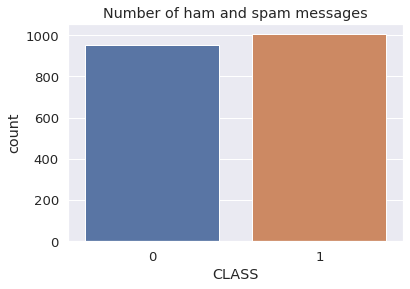

In [45]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(result.CLASS).set_title("Number of ham and spam messages")
plt.show()

In [46]:
result.describe()

,CLASS
count,1956.000000
mean,0.513804
std,0.499937
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


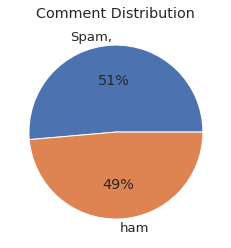

In [47]:
sms = pd.value_counts(result["CLASS"], sort=True)
sms.plot(kind="pie", labels=["Spam,", "ham"], autopct="%1.0f%%")

plt.title("Comment Distribution")
plt.ylabel("")
plt.show()

In [48]:
result['length'] = result.CONTENT.apply(len)
result.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,length
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,38
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39


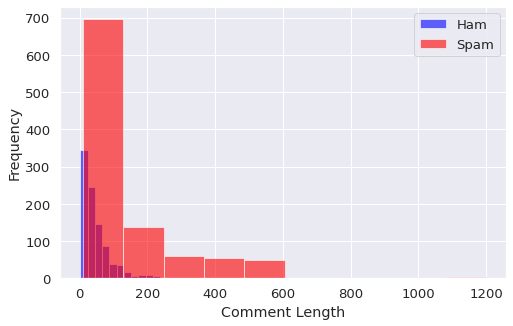

In [49]:
plt.figure(figsize=(8, 5))
result[result.CLASS == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
result[result.CLASS == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Comment Length");

In [50]:
# From above we learn only content and class columns are usefull 
# define our x and y
x = result.CONTENT
y = result.CLASS


In [51]:
# use sckit learn "train_test split" to split the data 
# into training and test data

ts= .2 
x_train, x_test, y_train, y_test = sp(x,y,random_state = 42, test_size = ts)

In [52]:
# this will 
#Tokenizer will transform the comments texts into space-separated sequences of words, and all punctuation is removed by default
# After that These sequences are then split into lists of tokens and indexed.
#The cat sat on the mat
#It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x_train)

In [53]:
#vect_x_train
print("Number of training instances: %d" % x_train.shape[0])
print("Number of Classes: %d" % len(set(y_train)))

Number of training instances: 1564
Number of Classes: 2


In [54]:
# get how many distinct words do we have in the dataset comments
voc_size =  len(tokenizer.word_index) + 1
print("Token size %d" % voc_size)

Token size 4257


In [55]:
# calculate the maximum document length
def max_length(x_train):
    return max([len(s.split()) for s in x_train])

print("Max comment length in all the training sample: %d " % max_length(x_train))

Max comment length in all the training sample: 172 


In [56]:
# encode a list of lines using tokenizer
def encode_text_Token(tokenizer, lines, length):


    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)

    
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

#BUILDING THE MODEL

In [57]:
# First, define the based sequential model (Building the structure of the model)


length = max_length(x_train)

#find length of the longest comment
#the input size will be adjusted to the length of the longest comment we have seen.
cnn_input = keras.layers.Input(shape =(length,))

#embedding layer will map the different words of the vocabulary that we have seen to a numeric vector representation.
#In our case, vocabulary size is the number of distinct words in our comments, and 100 means that we are going to represent each word
# word with a vector of size 100.
embedding = (keras.layers.Embedding(voc_size, 100)(cnn_input))


# The kernel size in the convolutional layer defines the number of words to consider as
#the convolution is passed across the input text, filter sees 4 words at each time (filter's window size).
# Relu returns 1 if the dot product is more than 0, otherwise it gives 0. (filter representation of the dot product)
conv_layer = keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding)


# we are reducing the effect of some of the neurons on the forward propagation to make the model more general
#here we regularized our model by droping out 0.2 (20%) of the neurons.
drop_layer = keras.layers.Dropout(0.3)(conv_layer)

# take the maximum of each 2 points. which means that the size of our convolutional layer will shrink by window of 2
pool_layer = (keras.layers.MaxPooling1D(pool_size=2))(drop_layer)



flat_layer = (keras.layers.Flatten())(pool_layer)
# reduces its impot to 10 output, normally we use it to merge different convolutional layers


dense_layer = (keras.layers.Dense(10, activation='relu'))(flat_layer)


# reduces the input to 1 output.
cnn_output = (keras.layers.Dense(1, activation='sigmoid'))(dense_layer)


#specify the model parameters, input and output

our_model=keras.models.Model(inputs = cnn_input, outputs = cnn_output)


#compiling the model. which means that now we have a ready model to process our data.
our_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
print(our_model.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 172)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 172, 100)          425700    
                                                                 
 conv1d_1 (Conv1D)           (None, 169, 32)           12832     
                                                                 
 dropout_1 (Dropout)         (None, 169, 32)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 84, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2688)              0         
                                                           

#Train the Model

In [58]:
from numpy import *
from keras.preprocessing.sequence import pad_sequences# Train our model on the training dataset
EncodedTrainX=encode_text_Token(tokenizer,x_train,length) #epochs represents how many times we are going to pass through
#the Whole dataset
# batch_size is just the number of instances that our model will handel each time (a segment of the training dataset)
history=our_model.fit(EncodedTrainX, array(y_train), epochs=20, batch_size=14)

Epoch 1/20
112/112 [==============================] - 3s 17ms/step - loss: 0.5556 - accuracy: 0.6803
Epoch 2/20
112/112 [==============================] - 2s 17ms/step - loss: 0.3514 - accuracy: 0.9514
Epoch 3/20
112/112 [==============================] - 2s 17ms/step - loss: 0.2959 - accuracy: 0.9853
Epoch 4/20
112/112 [==============================] - 2s 17ms/step - loss: 0.2632 - accuracy: 0.9910
Epoch 5/20
112/112 [==============================] - 2s 17ms/step - loss: 0.2392 - accuracy: 0.9955
Epoch 6/20
112/112 [==============================] - 2s 17ms/step - loss: 0.2207 - accuracy: 0.9955
Epoch 7/20
112/112 [==============================] - 2s 16ms/step - loss: 0.2040 - accuracy: 0.9955
Epoch 8/20
112/112 [==============================] - 2s 17ms/step - loss: 0.1889 - accuracy: 0.9968
Epoch 9/20
112/112 [==============================] - 2s 17ms/step - loss: 0.1753 - accuracy: 0.9968
Epoch 10/20
112/112 [==============================] - 2s 17ms/step - loss: 0.1632 - accura

#Evaluating the model

In [59]:
EncodedTestX = encode_text_Token(tokenizer, x_test, length)

# evaluating our model on the training dataset
loss, acc = our_model.evaluate(EncodedTrainX, array(y_train), verbose=0)
print('Train Accuracy: %f' % (acc*100))
 
# evaluating our model on the test dataset
loss, acc = our_model.evaluate(EncodedTestX,array(y_test), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Train Accuracy: 99.680305
Test Accuracy: 94.642860


In [60]:
from matplotlib import pyplot

In [61]:
print(EncodedTestX )

[[   1  335   34 ...    0    0    0]
 [ 191   16  105 ...    0    0    0]
 [  59  134   49 ...    0    0    0]
 ...
 [  68  709    4 ...    0    0    0]
 [   7    8    4 ...    0    0    0]
 [  80 3309   29 ...    0    0    0]]


#Confusion Matrix

In [62]:
#This Function converts the Probability of our model into labels
def ProToClass(ProList):
    ClassList=[]
    for x in ProList:
        if (x >= 0.5):
            ClassList.append(1)                
        else:
            ClassList.append(0)
    return ClassList

In [63]:
y_test_pre= our_model.predict(EncodedTestX)
# print(y_test)
# print(y_test_pre)
# y_test_pre=keras.utils.to_categorical(y_test_pre, num_classes=2)
y_test_pre = ProToClass(y_test_pre)
print("******************")
print("Confusion Matrix")
cm1 = confusion_matrix(y_test,y_test_pre,labels=[1, 0])
print(cm1)



******************
Confusion Matrix
[[179  10]
 [ 11 192]]


In [64]:
 from sklearn.metrics import confusion_matrix, classification_report


In [65]:
print(classification_report(y_test,y_test_pre))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       203
           1       0.94      0.95      0.94       189

    accuracy                           0.95       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392



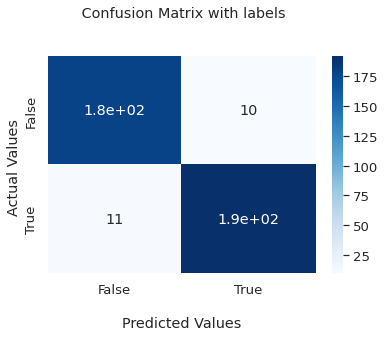

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cm1, annot=True, cmap='Blues')

ax.set_title(' Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

#Visualize our test set

In [67]:

import matplotlib.pyplot as plt

**********************************


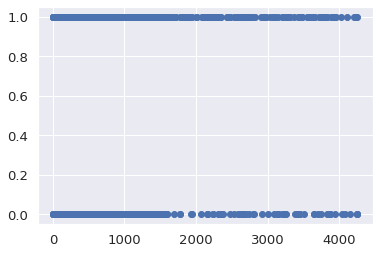

************************
Unique spam Words


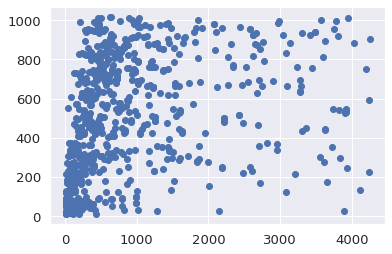

['the', 'and', 'to', 'check', 'out', 'a', 'my', 'you', 'on', 'fave', 'is', 'of', 'video', 'com', 'it', 'youtube', 'for', 'me', '39', 'please', 'like', 'in', 'subscribe', 'if', 'so', 'channel', 'love', 'just', 'http', 'sucking', 'music', 'can', 'amp', 'up', 'new', 'have', 'your', 'www', 'but', 'be', 'guys', 'will', 't', 'views', 'm', 'am', 'https', 'knew', 'all', 'at', 'money', 'get', 'from', 'make', 'hey', 'quot', 'arrowgance', 'with', 's', 'do', 'katy', 'who', '2', 'watch', 'u', 'videos', 'know', 'comment', 'we', 'thank', 'how', '3', 'facebook', 'supermariologan', 'as', 'time', 'or', 'our', 'thanks', 'one', 'im', 'really', 'see', 'nonsense', 'much', 'visit', 'us', 'help', 'by', 'here', 'no', 'her', 'he', 'called', '000', 'could', 'over', 'go', 'because', 'an', 'songs', 'has', 'give', 'should', 'perry', 'thumbs', 'still', 'free', 'want', 'some', 'about', 'today', 'does', 'share', 'its', 'now', 'piss', 'toilet', 'what', 'href', 'don', 'quiet', 'v', 'way', 'google', 'playlist', 'd', 'tak

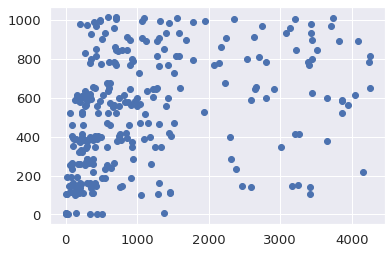

[None, 'i', '\ufeff', 'this', 'mom', 'works', 'da', 'months', 'checked', 'love\ufeff', 'br', 'song', 'huge', 'drunk', 'comprehend', 'elephant', 'that', 'cup', 'happening', 'listening', 'cant', 'bit', 'jackson', 'dumb', 'are', 'party\ufeff', 'ahhh', 'people', 'she', '1', 'finish', 'views\ufeff', 'wow\ufeff', 'saw', 'best', 'not', 'absolutely', 'complete', 'saying', 'box', 'checking', 'random', 'dick', 'copied', 'beauty', 'would', 'more', '♥\ufeff', "i've", 'away', 'was', 'bigger', 'bout', 'good', 'only', 'world', 'partying', 'old', 'sounds', 'pretty', 'eminem', '600', 'island', 'shuffle', 'lt', 'charlie', 'billion', 'rocks', 'says', 'sure', 'sucks', 'there', "isn't", 'cry', 'dislike', 'when', 'why', 'train', 'chance', 'now\ufeff', 'shakira', 'soundsofsunday', 'any', 'sty', 'year', 'wasn', 'awesome', 'lets', 'instead', 'number', 'beat', 'they', 'turn', 'pray', 'smh\ufeff', 'ever', 'nice', 'champion', 'animals', 'laugh', 'head', 'words', 'dude', 'song\ufeff', 'singing', 'wish', 'even', 'c

In [68]:
print("**********************************")
results = Visulize(EncodedTestX,y_test)
x= results[0]
y=results[1]
plt.scatter(x,y)
plt.show()
print("************************")
print("Unique spam Words")

spam=[]
data=[]
for i in range(len(x)) :
    if( y[i]==1 ):
        spam.append(x[i])
        data.append(i)
for w in spam:
    if w in results[0] and results[1] == 0 :
        i = spam.index(w)
        spam.remove(w)
        data[i].remove()
plt.scatter(spam,data)
plt.show()
spam = list(set(spam))
spam = sequence_to_text(spam)
print(spam)

print("************************")
print("Unique ham Words")

Ham=[]
data=[]
for i in range(len(x)) :
    if( y[i]==0):
        Ham.append(x[i])
        data.append(i)
for w in Ham:
    if w in results[0] and results[1] == 1 :
        i = Ham.index(w)
        Ham.remove(w)
        data[i].remove()
plt.scatter(Ham,data)
plt.show()
Ham = list(set(Ham))
Ham = sequence_to_text(Ham)
print(Ham)